# Columns Explanations
+ session_id - the ID of the session the event took place in
+ index - the index of the event for the session
+ elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
+ event_name - the name of the event type
+ name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
+ level - what level of the game the event occurred in (0 to 22)
+ page - the page number of the event (only for notebook-related events)
+ room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
+ room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
+ screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
+ screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
+ hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
+ text - the text the player sees during this event
+ fqid - the fully qualified ID of the event
+ room_fqid - the fully qualified ID of the room the event took place in
+ text_fqid - the fully qualified ID of the
+ fullscreen - whether the player is in fullscreen mode
+ hq - whether the game is in high-quality
+ music - whether the game music is on or off
+ level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

# Preparation

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from tqdm import tqdm
import missingno

warnings.simplefilter("ignore")
pd.options.display.max_columns=200
pd.options.display.max_rows=150

class CFG:
    INPUT = "../input"

Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 786 ('font.family:  IPAexGothic')
Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 787 ('figure.figsize: 16.4, 12.3')
Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 788 ('figure.dpi: 150')


In [2]:
%%time

train = pd.read_csv(f"{CFG.INPUT}/train.csv")
train_labels = pd.read_csv(f"{CFG.INPUT}/train_labels.csv")
test = pd.read_csv(f"{CFG.INPUT}/test.csv")
sample_submission = pd.read_csv(f"{CFG.INPUT}/sample_submission.csv")

train_labels[["session_id", "question"]] = train_labels.session_id.str.split("_", expand=True)
train_labels = train_labels[["session_id", "question", "correct"]]

display(train)
display(train_labels)
display(test)
display(sample_submission.sort_values("session_id"))

session_id  index  elapsed_time      event_name       name  \
0         20090312431273200      0             0  cutscene_click      basic   
1         20090312431273200      1          1323    person_click      basic   
2         20090312431273200      2           831    person_click      basic   
3         20090312431273200      3          1147    person_click      basic   
4         20090312431273200      4          1863    person_click      basic   
...                     ...    ...           ...             ...        ...   
26296941  22100221145014656   1600       5483231  navigate_click  undefined   
26296942  22100221145014656   1601       5485166  navigate_click  undefined   
26296943  22100221145014656   1602       5485917  navigate_click  undefined   
26296944  22100221145014656   1603       5486753  navigate_click  undefined   
26296945  22100221145014656   1604       5487952      checkpoint      basic   

          level  page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0             0   NaN  -413.991405  -159.314686          380.0          494.0   
1             0   NaN  -413.991405  -159.314686          380.0          494.0   
2             0   NaN  -413.991405  -159.314686          380.0          494.0   
3             0   NaN  -413.991405  -159.314686          380.0          494.0   
4             0   NaN  -412.991405  -159.314686          381.0          494.0   
...         ...   ...          ...          ...            ...            ...   
26296941     22   NaN   343.887291    36.701026          483.0          273.0   
26296942     22   NaN   332.696070   141.493178          545.0          221.0   
26296943     22   NaN   369.912859   140.569205          611.0          217.0   
26296944     22   NaN   252.299653   123.805889          526.0          232.0   
26296945     22   NaN          NaN          NaN            NaN            NaN   

          hover_duration                           text            fqid  \
0                    NaN                      undefined           intro   
1                    NaN  Whatcha doing over there, Jo?          gramps   
2                    NaN         Just talking to Teddy.          gramps   
3                    NaN     I gotta run to my meeting!          gramps   
4                    NaN            Can I come, Gramps?          gramps   
...                  ...                            ...             ...   
26296941             NaN                            NaN             NaN   
26296942             NaN                            NaN  chap4_finale_c   
26296943             NaN                            NaN             NaN   
26296944             NaN                            NaN  chap4_finale_c   
26296945             NaN                            NaN  chap4_finale_c   

                               room_fqid  \
0         tunic.historicalsociety.closet   
1         tunic.historicalsociety.closet   
2         tunic.historicalsociety.closet   
3         tunic.historicalsociety.closet   
4         tunic.historicalsociety.closet   
...                                  ...   
26296941            tunic.capitol_2.hall   
26296942            tunic.capitol_2.hall   
26296943            tunic.capitol_2.hall   
26296944            tunic.capitol_2.hall   
26296945            tunic.capitol_2.hall   

                                                  text_fqid  fullscreen  hq  \
0                      tunic.historicalsociety.closet.intro           0   0   
1         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
2         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
3         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
4         tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
...                                                     ...         ...  ..   
26296941                                                NaN           0   0   
26296942                         

session_id question  correct
0       20090312431273200       q1        1
1       20090312433251036       q1        0
2       20090312455206810       q1        1
3       20090313091715820       q1        0
4       20090313571836404       q1        1
...                   ...      ...      ...
424111  22100215342220508      q18        1
424112  22100215460321130      q18        1
424113  22100217104993650      q18        1
424114  22100219442786200      q18        1
424115  22100221145014656      q18        1

[424116 rows x 3 columns]

session_id  index  elapsed_time      event_name       name  \
0     20090109393214576      0             0  cutscene_click      basic   
1     20090109393214576      1          1965    person_click      basic   
2     20090109393214576      2          3614    person_click      basic   
3     20090109393214576      3          5330    person_click      basic   
4     20090109393214576      4          6397    person_click      basic   
...                 ...    ...           ...             ...        ...   
3723  20090312331414616   1001       1581679       map_hover      basic   
3724  20090312331414616   1002       1583044       map_hover      basic   
3725  20090312331414616   1003       1583410       map_click  undefined   
3726  20090312331414616   1004       1585841  navigate_click  undefined   
3727  20090312331414616   1005       1587810      checkpoint      basic   

      level  page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0         0   NaN  -413.991405    75.685314          380.0          259.0   
1         0   NaN  -105.991405   -63.314686          688.0          398.0   
2         0   NaN  -418.991405    47.685314          375.0          287.0   
3         0   NaN  -110.991405   -57.314686          683.0          392.0   
4         0   NaN  -110.991405   -57.314686          683.0          392.0   
...     ...   ...          ...          ...            ...            ...   
3723     22   NaN          NaN          NaN            NaN            NaN   
3724     22   NaN          NaN          NaN            NaN            NaN   
3725     22   NaN   483.726363    -3.880047          456.0          332.0   
3726     22   NaN   192.372139    38.216178          383.0          272.0   
3727     22   NaN          NaN          NaN            NaN            NaN   

      hover_duration                           text             fqid  \
0                NaN                      undefined            intro   
1                NaN  Whatcha doing over there, Jo?           gramps   
2                NaN         Just talking to Teddy.           gramps   
3                NaN     I gotta run to my meeting!           gramps   
4                NaN            Can I come, Gramps?           gramps   
...              ...                            ...              ...   
3723           484.0                            NaN   tunic.wildlife   
3724           783.0                            NaN  tunic.capitol_2   
3725             NaN                            NaN  tunic.capitol_2   
3726             NaN                            NaN   chap4_finale_c   
3727             NaN                            NaN   chap4_finale_c   

                           room_fqid  \
0     tunic.historicalsociety.closet   
1     tunic.historicalsociety.closet   
2     tunic.historicalsociety.closet   
3     tunic.historicalsociety.closet   
4     tunic.historicalsociety.closet   
...                              ...   
3723   tunic.historicalsociety.entry   
3724   tunic.historicalsociety.entry   
3725   tunic.historicalsociety.entry   
3726            tunic.capitol_2.hall   
3727            tunic.capitol_2.hall   

                                              text_fqid  fullscreen  hq  \
0                  tunic.historicalsociety.closet.intro           0   0   
1     tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
2     tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
3     tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
4     tunic.historicalsociety.closet.gramps.intro_0_...           0   0   
...                                                 ...         ...  ..   
3723                                                NaN           0   0   
3724                                                NaN           0   0   
3725                                                NaN           0   0   
3726                                                NaN           0   0   
3727            

session_id  correct  session_level
0    20090109393214576_q1        0            NaN
27  20090109393214576_q10        0            NaN
30  20090109393214576_q11        0            NaN
33  20090109393214576_q12        0            NaN
36  20090109393214576_q13        0            NaN
39  20090109393214576_q14        0            NaN
42  20090109393214576_q15        0            NaN
45  20090109393214576_q16        0            NaN
48  20090109393214576_q17        0            NaN
51  20090109393214576_q18        0            NaN
3    20090109393214576_q2        0            NaN
6    20090109393214576_q3        0            NaN
9    20090109393214576_q4        0            NaN
12   20090109393214576_q5        0            NaN
15   20090109393214576_q6        0            NaN
18   20090109393214576_q7        0            NaN
21   20090109393214576_q8        0            NaN
24   20090109393214576_q9        0            NaN
1    20090312143683264_q1        0            NaN
28  20090312143683264_q10        0            NaN
31  20090312143683264_q11        0            NaN
34  20090312143683264_q12        0            NaN
37  20090312143683264_q13        0            NaN
40  20090312143683264_q14        0            NaN
43  20090312143683264_q15        0            NaN
46  20090312143683264_q16        0            NaN
49  20090312143683264_q17        0            NaN
52  20090312143683264_q18        0            NaN
4    20090312143683264_q2        0            NaN
7    20090312143683264_q3        0            NaN
10   20090312143683264_q4        0            NaN
13   20090312143683264_q5        0            NaN
16   20090312143683264_q6        0            NaN
19   20090312143683264_q7        0            NaN
22   20090312143683264_q8        0            NaN
25   20090312143683264_q9        0            NaN
2    20090312331414616_q1        0            NaN
29  20090312331414616_q10        0            NaN
32  20090312331414616_q11        0            NaN
35  20090312331414616_q12        0            NaN
38  20090312331414616_q13        0            NaN
41  20090312331414616_q14        0            NaN
44  20090312331414616_q15        0            NaN
47  20090312331414616_q16        0            NaN
50  20090312331414616_q17        0            NaN
53  20090312331414616_q18        0            NaN
5    20090312331414616_q2        0            NaN
8    20090312331414616_q3        0            NaN
11   20090312331414616_q4        0            NaN
14   20090312331414616_q5        0            NaN
17   20090312331414616_q6        0            NaN
20   20090312331414616_q7        0            NaN
23   20090312331414616_q8        0            NaN
26   20090312331414616_q9        0            NaN

CPU times: user 35.7 s, sys: 6.31 s, total: 42 s
Wall time: 42.5 s


# EDA

## Correct Rate

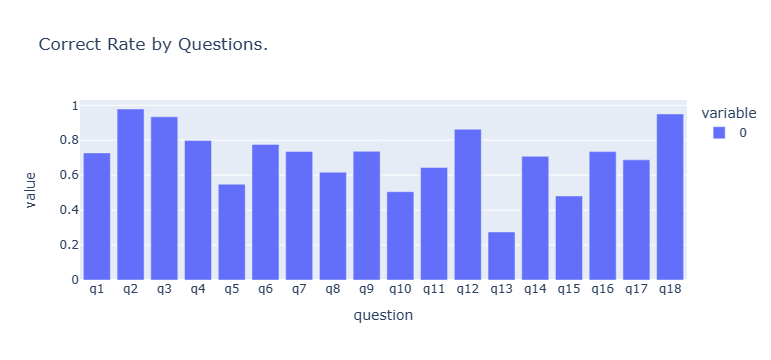

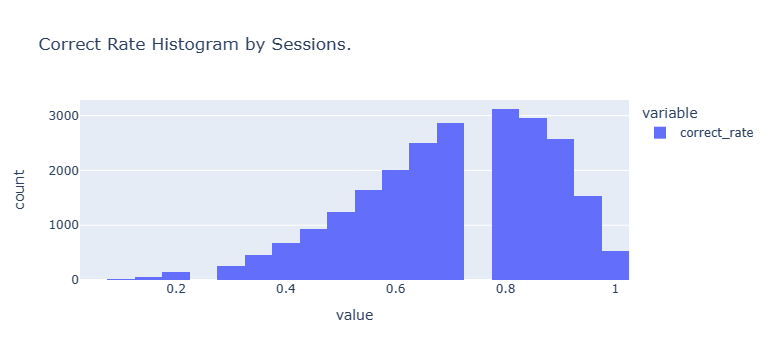

question           q1  q2  q3  q4  q5  q6  q7  q8  q9  q10  q11  q12  q13  \
session_id                                                                  
20090312431273200   1   1   1   1   1   1   1   1   1    1    1    1    0   
20090312433251036   0   1   1   1   0   1   1   0   1    0    0    1    0   
20090312455206810   1   1   1   1   1   1   1   1   1    1    1    1    1   
20090313091715820   0   1   1   1   1   0   1   1   1    0    0    1    0   
20090313571836404   1   1   1   1   1   1   1   1   1    1    1    0    1   
...                ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
22100215342220508   1   1   1   1   1   1   1   0   1    1    1    1    0   
22100215460321130   0   1   1   1   0   1   1   0   1    0    1    1    0   
22100217104993650   1   1   1   1   1   1   1   1   1    0    1    1    1   
22100219442786200   0   1   1   1   1   1   1   0   1    0    1    1    0   
22100221145014656   0   1   0   1   0   0   0   0   1    0    1    1    0   

question           q14  q15  q16  q17  q18  correct_rate relative_group  \
session_id                                                                
20090312431273200    1    1    0    1    1      0.888889              4   
20090312433251036    1    0    1    0    1      0.555556              1   
20090312455206810    1    0    1    1    1      0.944444              4   
20090313091715820    1    0    1    1    1      0.666667              2   
20090313571836404    0    1    1    1    1      0.888889              4   
...                ...  ...  ...  ...  ...           ...            ...   
22100215342220508    1    1    1    1    1      0.888889              4   
22100215460321130    1    0    1    1    1      0.666667              2   
22100217104993650    1    0    0    1    1      0.833333              3   
22100219442786200    1    0    1    1    1      0.722222              2   
22100221145014656    0    0    0    1    1      0.388889              1   

question          abs_group  
session_id                   
20090312431273200         4  
20090312433251036         3  
20090312455206810         4  
20090313091715820         3  
20090313571836404         4  
...                     ...  
22100215342220508         4  
22100215460321130         3  
22100217104993650         4  
22100219442786200         3  
22100221145014656         2  

[23562 rows x 21 columns]

In [3]:
questions = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18']

check = pd.pivot(data=train_labels, index="session_id", columns="question", values="correct")
check = check[questions]

display(px.bar(check.mean(axis=0), title="Correct Rate by Questions."))

check["correct_rate"] = check.mean(axis=1)
display(px.histogram(check.correct_rate, title="Correct Rate Histogram by Sessions." ))

check["relative_group"] = pd.qcut(check.correct_rate, 4, labels=[1, 2, 3, 4])
check["abs_group"] = pd.cut(check.correct_rate, 4, labels=[1, 2, 3, 4])

display(check)

CPU times: user 43.4 s, sys: 159 ms, total: 43.6 s
Wall time: 43.6 s


Text(0.5, 1.0, 'correct/uncorrect cooccurence_rate between questions')

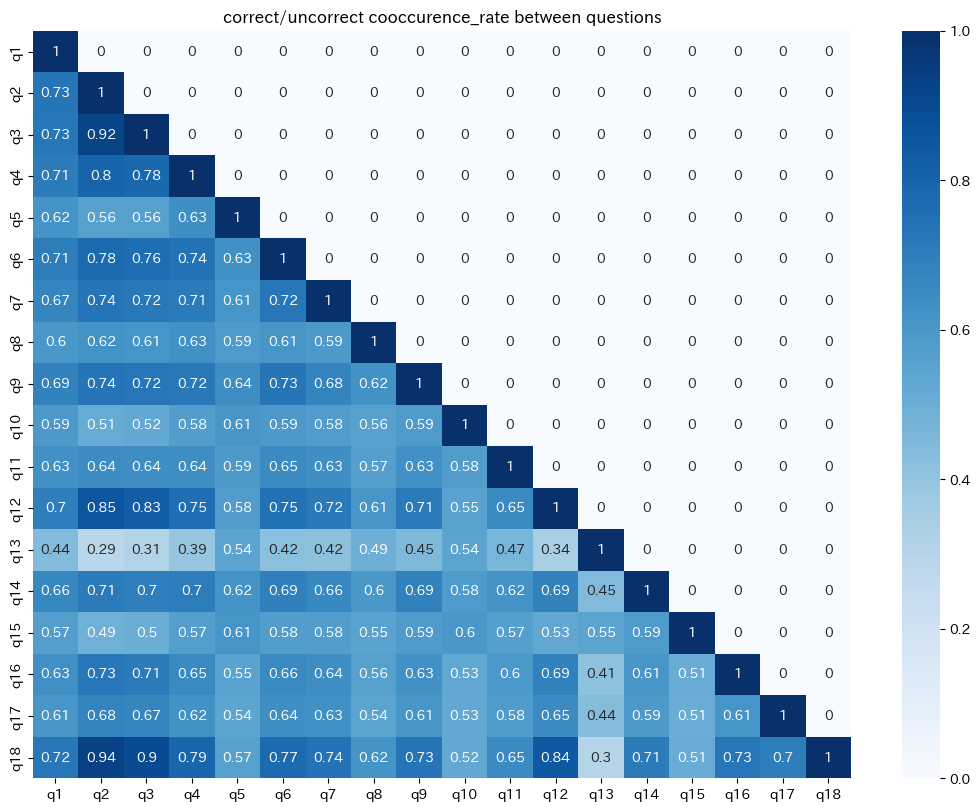

In [4]:
%%time

res = {}

for session_id, row in check[questions].iterrows():
    tmp = []
    for i1, q1 in enumerate(row):
        for i2, q2 in enumerate(row):
            tmp.append((questions[i1], questions[i2], int(q1==q2)))
    tmp = pd.DataFrame(tmp)
    tmp = pd.pivot(data=tmp, index=0, columns=1, values=2)
    res[session_id] = np.array(tmp.reindex(index=questions, columns=questions))

cooccurence_rate = np.sum(list(res.values()), axis=0) / len(res.keys())
cooccurence_rate = pd.DataFrame(data=np.tril(cooccurence_rate), columns=questions)
cooccurence_rate.index = questions

sns.heatmap(cooccurence_rate, cmap="Blues", annot=True)
plt.title("correct/uncorrect cooccurence_rate between questions");

In [5]:
check.relative_group.value_counts().sort_index()
check.abs_group.value_counts().sort_index()
check.correct_rate.describe()

1    7460
2    5368
3    6084
4    4650
Name: relative_group, dtype: int64

1      496
2     3315
3     9017
4    10734
Name: abs_group, dtype: int64

count    23562.000000
mean         0.705635
std          0.172455
min          0.055556
25%          0.611111
50%          0.722222
75%          0.833333
max          1.000000
Name: correct_rate, dtype: float64

## Variables

### train data

#### base analysis

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 3.9+ GB


In [7]:
print("Null Rate")
train.isnull().sum() / len(train)

Null Rate


session_id        0.000000
index             0.000000
elapsed_time      0.000000
event_name        0.000000
name              0.000000
level             0.000000
page              0.978532
room_coor_x       0.078841
room_coor_y       0.078841
screen_coor_x     0.078841
screen_coor_y     0.078841
hover_duration    0.923860
text              0.634287
fqid              0.314653
room_fqid         0.000000
text_fqid         0.634283
fullscreen        0.000000
hq                0.000000
music             0.000000
level_group       0.000000
dtype: float64

<AxesSubplot: >

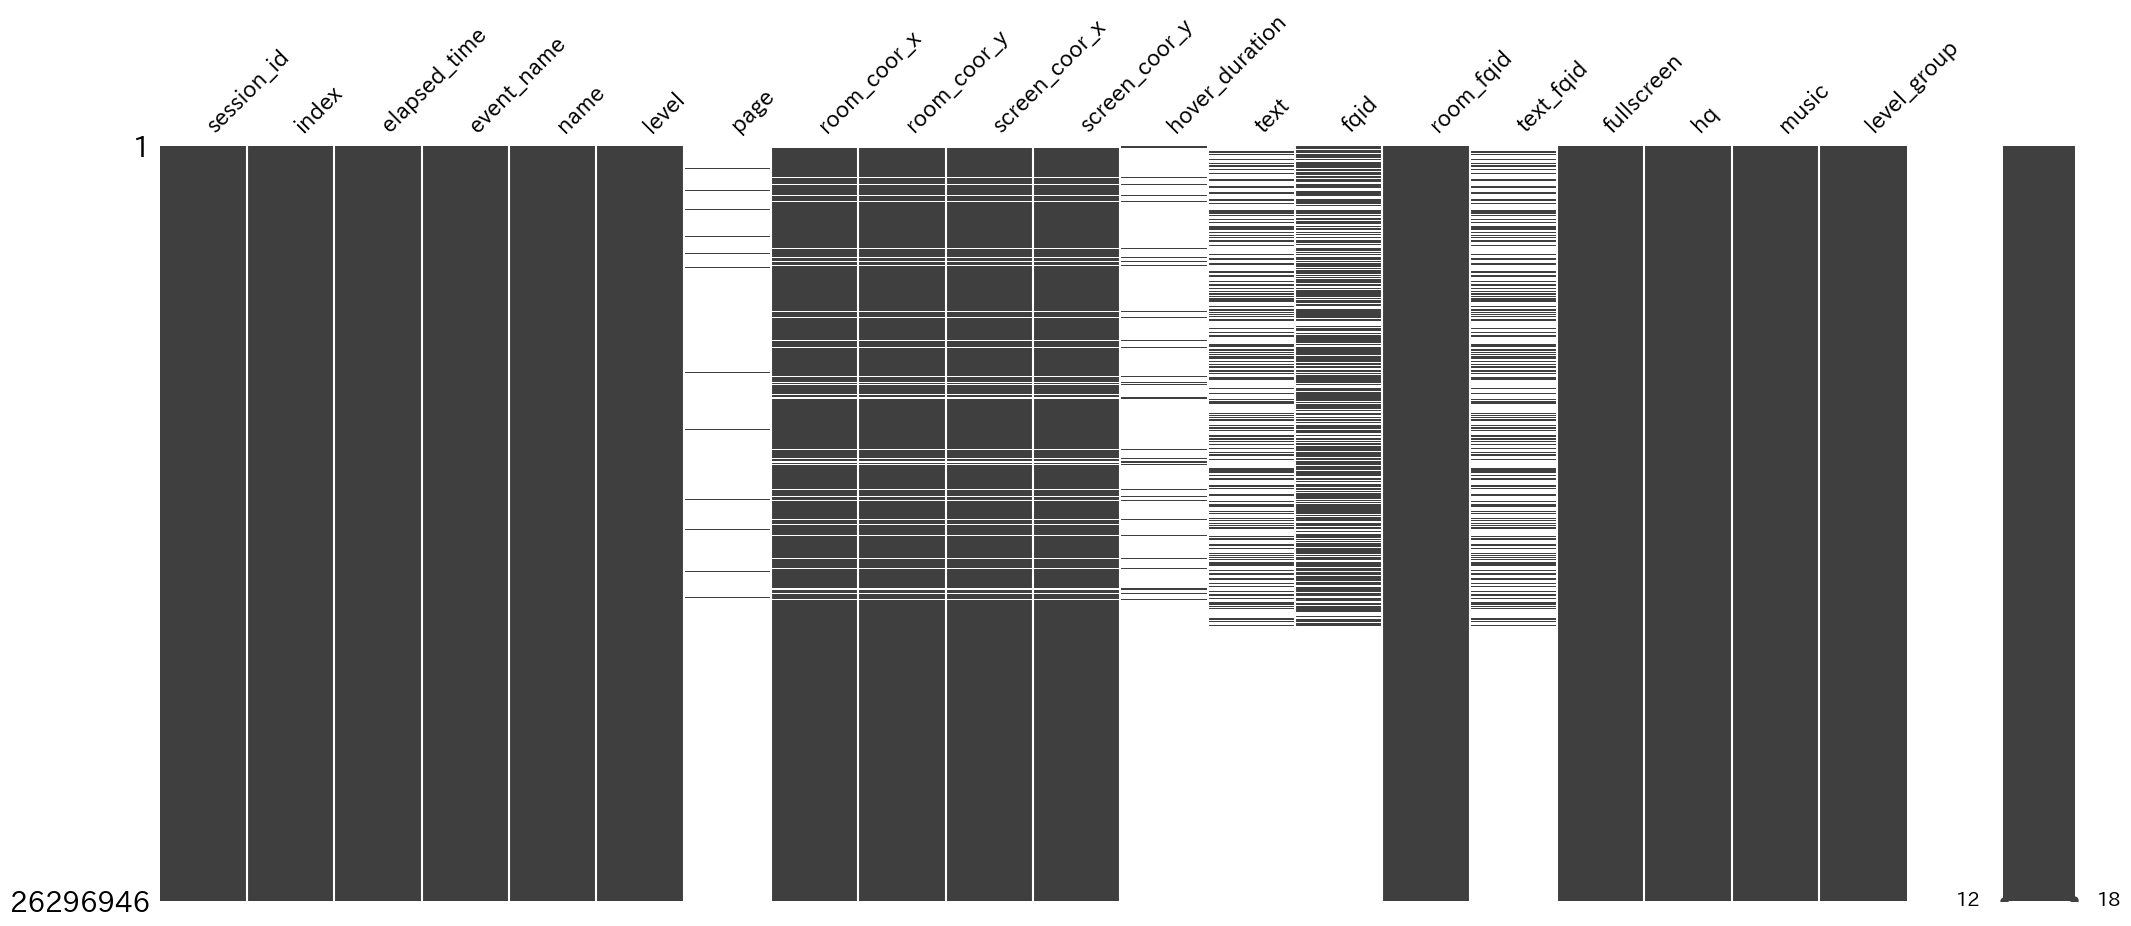

In [8]:
missingno.matrix(train)

In [9]:
train.describe()

session_id         index  elapsed_time         level           page  \
count  2.629695e+07  2.629695e+07  2.629695e+07  2.629695e+07  564544.000000   
mean   2.113249e+16  6.445102e+02  4.016694e+06  1.219169e+01       3.166559   
std    5.712953e+14  5.457880e+02  3.127032e+07  6.497789e+00       2.063291   
min    2.009031e+16  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    2.101022e+16  2.880000e+02  4.397000e+05  6.000000e+00       1.000000   
50%    2.104021e+16  5.950000e+02  1.014801e+06  1.300000e+01       3.000000   
75%    2.110052e+16  8.960000e+02  1.747040e+06  1.800000e+01       5.000000   
max    2.210022e+16  2.047300e+04  1.988607e+09  2.200000e+01       6.000000   

        room_coor_x   room_coor_y  screen_coor_x  screen_coor_y  \
count  2.422367e+07  2.422367e+07   2.422367e+07   2.422367e+07   
mean  -5.490579e+01 -1.162119e+02   4.584098e+02   3.855860e+02   
std    5.202926e+02  2.184710e+02   2.479389e+02   1.298166e+02   
min   -1.992355e+03 -9.181623e+02   0.000000e+00   0.000000e+00   
25%   -3.528395e+02 -2.127183e+02   2.690000e+02   3.040000e+02   
50%   -1.116280e+01 -9.760534e+01   4.470000e+02   3.970000e+02   
75%    2.966515e+02  2.268786e+01   6.630000e+02   4.710000e+02   
max    1.261774e+03  5.436164e+02   1.919000e+03   1.440000e+03   

       hover_duration    fullscreen            hq         music  
count    2.002244e+06  2.629695e+07  2.629695e+07  2.629695e+07  
mean     3.471003e+03  1.370037e-01  1.202047e-01  9.293778e-01  
std      4.602024e+05  3.438513e-01  3.252008e-01  2.561926e-01  
min      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%      9.900000e+01  0.000000e+00  0.000000e+00  1.000000e+00  
50%      4.190000e+02  0.000000e+00  0.000000e+00  1.000000e+00  
75%      1.266000e+03  0.000000e+00  0.000000e+00  1.000000e+00  
max      2.451637e+08  1.000000e+00  1.000000e+00  1.000000e+00

#### create eda train dataset

In [12]:
%%time

tmp = check[["correct_rate", "relative_group", "abs_group"]].reset_index()
tmp.session_id = tmp.session_id.astype(int)
train4eda = pd.merge(train, tmp, how = "left", on = "session_id")

tmp = []
for i, row in tqdm(train[["fqid", "room_fqid", "text_fqid"]].fillna("").iterrows()):
    tfqid = row.text_fqid.replace(row.room_fqid, "").replace(row.fqid, "")
    tfqid = tfqid.replace("..", ".")
    tmp.append(tfqid[1:] if tfqid.startswith(".") else None)
train4eda["text_fqid"] = tmp

train4eda["room_fqid"] = [f.replace("tunic.", "") for f in train4eda.room_fqid]
train4eda[["room_fqid_1st", "room_fqid_2nd"]] = train4eda.room_fqid.str.split(".", expand=True)

train4eda[["fqid_"+i for i in ["1st", "2nd", "3rd"]]] = train4eda.fqid.str.split(".", expand=True)
train4eda["fqid_1st"] = [fqid.split("_")[0] if b else None for fqid,b in zip(train4eda["fqid_1st"], train4eda["fqid_1st"].notnull())]
train4eda["fqid_2nd"] = [fqid.split("_")[0] if b else None for fqid,b in zip(train4eda["fqid_2nd"], train4eda["fqid_2nd"].notnull())]

train4eda[["text_fqid_"+i for i in ["1st", "2nd", "3rd"]]] = train4eda.text_fqid.str.split(".", expand=True)
train4eda["text_fqid_1st"] = [text_fqid.split("_")[0] if b else None for fqid,b in zip(train4eda["text_fqid_1st"], train4eda["text_fqid_1st"].notnull())]
train4eda["text_fqid_2nd"] = [text_fqid.split("_")[0] if b else None for fqid,b in zip(train4eda["text_fqid_2nd"], train4eda["text_fqid_2nd"].notnull())]

train4eda[["event_name", "event_type"]] = train4eda.event_name.str.split("_", expand=True)

26296946it [24:15, 18071.24it/s]


NameError: name 'text_fqid' is not defined

In [13]:
train4eda.text_fqid.value_counts().sort_index()

                                  2915390
afterteddy                          93074
animals                             97526
animals2                            15726
archivist                           10156
badger                              67720
beforeteddy                         31751
businesscards.card_bingo.bingo      23805
colorbook                           23706
concern                               317
confrontation                      263308
confrontation_recap                 13235
crane                              470755
directory.closeup.archivist         49298
done                               114238
done2                                4754
droppedbadge                         2168
flag                               531762
flag_recap                          18166
found                              216279
foundtheodora                        6870
have_glass                         394908
have_glass_recap                    28435
haveyougotit                      

#### continuous variances

#### relations between fqids

In [14]:
pd.options.display.max_rows=200
train.groupby(["fqid", "room_fqid", "text_fqid"])["session_id", "index"].count()

session_id  \
fqid               room_fqid                               text_fqid                                                        
archivist          tunic.historicalsociety.frontdesk       tunic.historicalsociety.frontdesk.archivist.fou...        6870   
                                                           tunic.historicalsociety.frontdesk.archivist.hav...      394908   
                                                           tunic.historicalsociety.frontdesk.archivist.hav...       28435   
                                                           tunic.historicalsociety.frontdesk.archivist.hello       131885   
                                                           tunic.historicalsociety.frontdesk.archivist.nee...        8206   
                                                           tunic.historicalsociety.frontdesk.archivist.nee...        5830   
                                                           tunic.historicalsociety.frontdesk.archivist.new...      429762   
                                                           tunic.historicalsociety.frontdesk.archivist.new...        5487   
archivist_glasses  tunic.historicalsociety.frontdesk       tunic.historicalsociety.frontdesk.archivist_gla...      263308   
                                                           tunic.historicalsociety.frontdesk.archivist_gla...       13235   
block              tunic.historicalsociety.stacks          tunic.historicalsociety.stacks.block                      6095   
block_0            tunic.drycleaner.frontdesk              tunic.drycleaner.frontdesk.block_0                         221   
                   tunic.humanecology.frontdesk            tunic.humanecology.frontdesk.block_0                      4059   
                   tunic.kohlcenter.halloffame             tunic.kohlcenter.halloffame.block_0                        434   
                   tunic.library.microfiche                tunic.library.microfiche.block_0                           985   
block_1            tunic.drycleaner.frontdesk              tunic.drycleaner.frontdesk.block_1                           3   
                   tunic.humanecology.frontdesk            tunic.humanecology.frontdesk.block_1                        13   
block_badge        tunic.library.frontdesk                 tunic.library.frontdesk.block_badge                        777   
block_badge_2      tunic.library.frontdesk                 tunic.library.frontdesk.block_badge_2                      479   
block_magnify      tunic.historicalsociety.frontdesk       tunic.historicalsociety.frontdesk.block_magnify           7678   
block_nelson       tunic.library.frontdesk                 tunic.library.frontdesk.block_nelson                      1102   
block_tocollection tunic.historicalsociety.entry           tunic.historicalsociety.entry.block_tocollection           937   
block_tomap1       tunic.historicalsociety.entry           tunic.historicalsociety.entry.block_tomap1                 836   
block_tomap2       tunic.historicalsociety.entry           tunic.historicalsociety.entry.block_tomap2                1780   
boss               tunic.capitol_0.hall                    tunic.capitol_0.hall.boss.talktogramps                   13183   
                   tunic.capitol_1.hall                    tunic.capitol_1.hall.boss.haveyougotit                   20733   
                                                           tunic.capitol_1.hall.boss.writeitup                       6140   
                   tunic.capitol_2.hall                    tunic.capitol_2.hall.boss.haveyougotit                   41565   
                   tunic.historicalsociety.entry           tunic.historicalsociety.entry.boss.flag                 119983   
                                                           tunic.historicalsociety.entry.boss.flag_recap             8688   
                                                           tunic.historicalsociety.entry.boss.talktogramps     

In [15]:
train4eda.room_fqid.str.split(".", expand=True)
train4eda.fqid.str.split(".", expand=True).rename(columns={0:"1st", 1:"2nd", 2:"3rd"}).value_counts(dropna=False).sort_index()

0       1
0         historicalsociety  closet
1         historicalsociety  closet
2         historicalsociety  closet
3         historicalsociety  closet
4         historicalsociety  closet
...                     ...     ...
26296941          capitol_2    hall
26296942          capitol_2    hall
26296943          capitol_2    hall
26296944          capitol_2    hall
26296945          capitol_2    hall

[26296946 rows x 2 columns]

1st                 2nd                3rd       
archivist           NaN                NaN           1127341
archivist_glasses   NaN                NaN            316855
block               NaN                NaN             13378
block_0             NaN                NaN             11726
block_1             NaN                NaN                37
block_badge         NaN                NaN              1642
block_badge_2       NaN                NaN               993
block_magnify       NaN                NaN             15629
block_nelson        NaN                NaN              2293
block_tocollection  NaN                NaN              2304
block_tomap1        NaN                NaN              1760
block_tomap2        NaN                NaN              3990
boss                NaN                NaN            303627
businesscards       card_0             next            92287
                    card_1             next            63402
                    card_bingo     

CPU times: user 8.08 s, sys: 4.72 s, total: 12.8 s
Wall time: 13.5 s


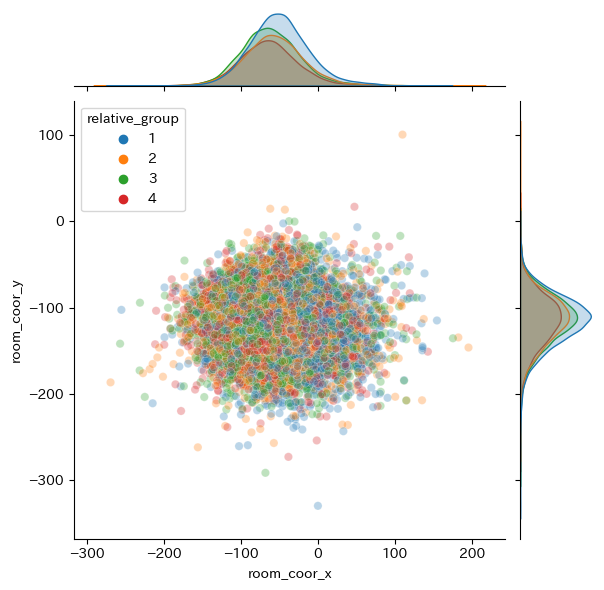

In [16]:
%%time

x="room_coor_x"
y="room_coor_y"

tmp = train4eda.groupby(["session_id", "relative_group"])[[x,y]].mean().reset_index()
sns.jointplot(data=tmp, x=x, y=y, hue="relative_group", alpha=.3)

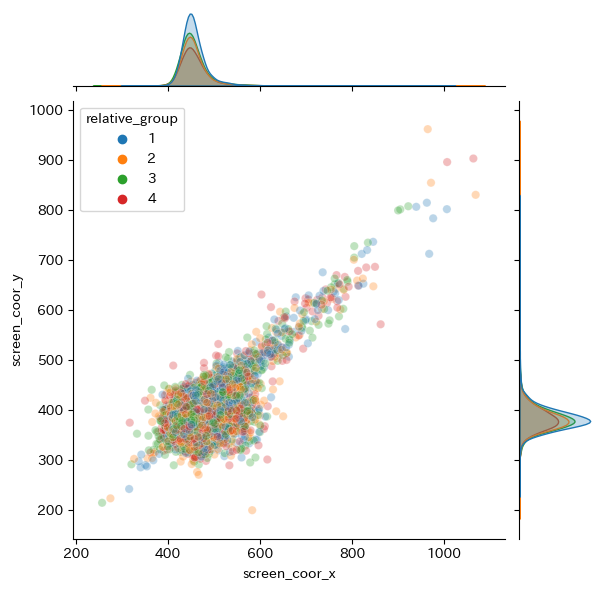

In [17]:
x="screen_coor_x"
y="screen_coor_y"

tmp = train4eda.groupby(["session_id", "relative_group"])[[x,y]].mean().reset_index()
sns.jointplot(data=tmp, x=x, y=y, hue="relative_group", alpha=.3)

In [18]:
print("Number of unique sessions", train4eda.session_id.nunique())
tmp = train4eda.groupby(["session_id", "relative_group"]).agg(logs_in_a_session=("index", "count"))
tmp = tmp[tmp>0].reset_index()
px.histogram(data_frame=tmp, x="logs_in_a_session", color="relative_group", opacity=.3,
             barmode="overlay", title="number of logs in a session")

Number of unique sessions 23562


In [19]:
tmp = train4eda.groupby(["session_id", "relative_group"]).agg(max_elapsed_time_in_a_session=("elapsed_time", "max")).reset_index()
tmp = tmp[tmp.max_elapsed_time_in_a_session.notnull()].sort_values("relative_group")
#tmp.max_elapsed_time_in_a_session /= 1e6
px.histogram(data_frame=tmp, x="max_elapsed_time_in_a_session", color="relative_group", opacity=.3,
             barmode="overlay", title="max_elapsed_time_in_a_session", histnorm="probability", cumulative=True,
             facet_row="relative_group", height=800)

#### categorical variances

In [20]:
group = "relative_group"

for col in train4eda.columns:
    if train4eda[col].dtype == object:
        if len(train4eda[col].unique()) <= 40:
            tmp = [train4eda.query(f"{group}=={g}").value_counts([group, col], dropna=False, normalize=True).reset_index()
           for g in train4eda[group].unique()]
            tmp = pd.concat(tmp, axis=0, ignore_index=True).sort_values([group,col]).reset_index(drop=True)
            display(px.bar(data_frame=tmp.rename(columns={0:"rate"}), x=col, y="rate", color=group, barmode="group"))
        else:
            print(f"{col} has so much various values.")

text has so much various values.
fqid has so much various values.


text_fqid has so much various values.


fqid_1st has so much various values.


text_fqid_1st has so much various values.


In [21]:
train4eda.value_counts(["event_type", "event_name", "name"], dropna=False, normalize=True).sort_index()

KeyError: 'event_type'

In [ ]:
train4eda[["fqid_1st", "fqid_2nd", "fqid_3rd"]].value_counts(dropna=False).sort_index()

In [ ]:
sns.jointplot(x=test.room_coor_x, y=test.room_coor_y, alpha=.3)
sns.jointplot(x=test.screen_coor_x, y=test.screen_coor_y, alpha=.3)